In [1]:
import os
import shutil
import cv2
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import ToTensor
import pandas as pd

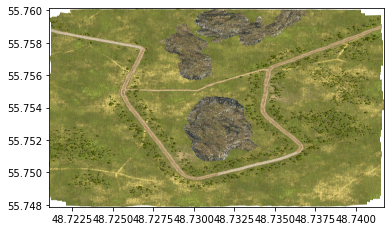

<AxesSubplot:>

In [2]:
filepath = '/home/judicator/data/dozer_export/orthomosaic/dozer_north_orthomosaic.tif'
img = rasterio.open(filepath)
show(img)

In [3]:
with rasterio.open(filepath) as fp:
    np_map = np.array(fp.read())
np_map = np.transpose(np_map, (1, 2, 0))

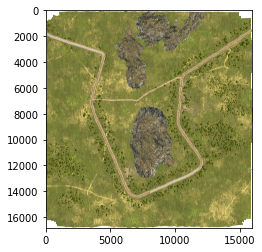

In [4]:
plt.imshow(np_map)

In [5]:
from src.models.segmentation.unet import UNet

In [6]:
model = UNet(num_classes=4, input_channels=3, num_layers=5, features_start=16)

In [7]:
state_dict = torch.load(
    '/home/judicator/ev/training-pipeline/runs/2022-05-22_14:38:29__unet_sim_size:256_feats:16/trained_models/unet_sim_size:256_feats:16.pt'
)

keys = list(state_dict.keys())

for key in keys:
    if key.startswith('model.'):
        new_key = '.'.join(key.split('.')[1:])
        state_dict[new_key] = state_dict[key]
        state_dict.pop(key)

In [8]:
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [9]:
model.eval()

UNet(
  (layers): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): Down(
      (net): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (net): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): Batch

In [10]:
input_size = (1024, 1024)

img_np = np_map[2000:2000+input_size[0], 6000:6000+input_size[1], :-1]
input_tensor = ToTensor()(img_np).unsqueeze(0)

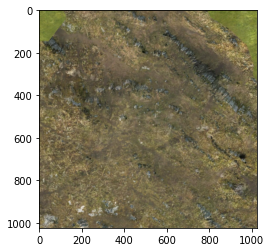

In [11]:
plt.imshow(img_np)

In [12]:
with torch.no_grad():
    pred = np.array(model(input_tensor))

In [13]:
pred = pred[0].argmax(axis=0)

In [14]:
mask = np.zeros((input_size[0], input_size[1], 3), dtype=np.uint8)

In [15]:
classes_rgb = [
    [162,212,163],
    [220,193,224],
    [218,255,183],
    [255,255,255]
]

In [16]:
for i in range(len(classes_rgb)):
    mask[pred == i] = classes_rgb[i]

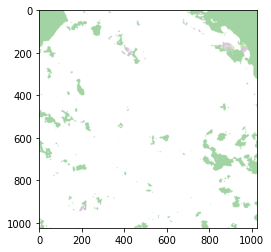

In [17]:
plt.imshow(mask)

In [18]:
height = 1024
width = 1024

In [19]:
padded_map = np.zeros(
    (
        (np_map.shape[0] // height + 1) * height,
        (np_map.shape[1] // width + 1) * width,
        3
    ),
    dtype=np.uint8
)
padded_map[0:np_map.shape[0], 0:np_map.shape[1]] = np_map[:, :, :-1]

In [20]:
np_map_mask = np.zeros_like(padded_map, dtype=np.uint8)

In [21]:
for i in range(padded_map.shape[0] // height):
    for j in range(padded_map.shape[1] // width):
        img = padded_map[i*height:(i+1)*height, j*width:(j+1)*width]
        input_tensor = ToTensor()(img).unsqueeze(0)
        with torch.no_grad():
            pred = np.array(model(input_tensor))
        pred = pred[0].argmax(axis=0)
        mask = np.zeros((height, width, 3), dtype=np.uint8)
        for k in range(len(classes_rgb)):
            mask[pred == k] = classes_rgb[k]
        np_map_mask[i*width:(i+1)*width, j*height:(j+1)*height] = mask

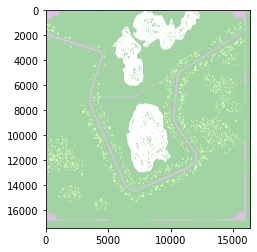

In [22]:
plt.imshow(np_map_mask)

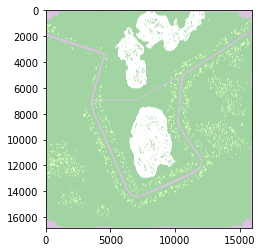

In [23]:
np_map_mask_fine = np_map_mask[0:np_map.shape[0], 0:np_map.shape[1]]
plt.imshow(np_map_mask_fine)

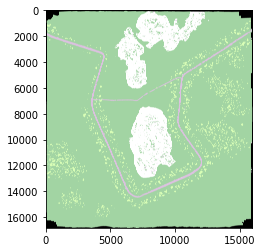

In [24]:
np_map_mask_fine[(np_map == [255, 255, 255, 0])[:, :, :-1]] = 0
plt.imshow(np_map_mask_fine)

In [25]:
alpha_channel = (np.ones((np_map_mask_fine.shape[0], np_map_mask_fine.shape[1])) * 255).astype(np.uint8)
alpha_channel[(np_map_mask_fine == [0, 0, 0])[:, :, 0]] = 0

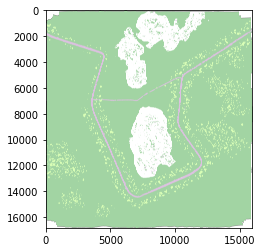

In [26]:
np_map_mask_alpha = np.dstack((np_map_mask_fine, alpha_channel))
plt.imshow(np_map_mask_alpha)

In [33]:
plt.imsave('/home/judicator/data/dozer_export/orthomosaic/dozer_north_orthomosaic_segmented.png', np_map_mask_alpha)

In [ ]:
np_map_and_mask = np.concatenate((np_map, np_map_mask_alpha), axis=1, dtype=np.uint8)
plt.imshow(np_map_and_mask)

(872, 1652, 4)


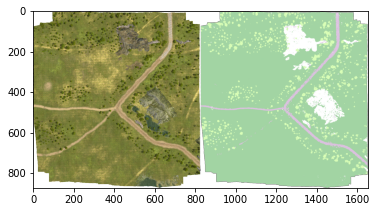

In [90]:
np_map_and_mask_resized = cv2.resize(np_map_and_mask, (1652, 872))
print(np_map_and_mask_resized.shape)
plt.imshow(np_map_and_mask_resized)

In [91]:
plt.imsave('/home/judicator/data/dozer_export/orthomosaic/dozer_east_ortho_and_mask.png', np_map_and_mask_resized)